In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import make_scorer, classification_report, make_scorer, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import time

# importing training set
train_df = pd.read_csv("../data/avis/train_noYC_lemma_sent_equil.csv", index_col=0)
# split between features(X) and target(y)
y_train = train_df.etoiles -1 # les classes doivent commencer à 0, remettre +1 pour interpretation!
X_train = train_df.drop("etoiles", axis = 1)
X_train = X_train[['n_avis','sentiment_norm','longueur_texte']]

# importing test set
test_df = pd.read_csv('../data/avis/test_noYC_lemma_sent_equil.csv')
# split between features(X) and target(y)
X_test = test_df.drop("etoiles", axis =1)
X_test = X_test[['n_avis','sentiment_norm','longueur_texte']]
y_test = test_df['etoiles'] -1 # les classes doivent commencer à 0, remettre +1 pour interpretation!

model_type = "XGBoost"

X_train.head(3)

n_avis  sentiment_norm  longueur_texte
5529      1.0        0.804014              95
57109     1.0        0.974431              73
83051     3.0        0.631495              85

In [3]:
# Fonctions de vectorisation et de reporting
def model_report():
    # measuring time taken to train the model
    t1 = time.time()
    delais = round((t1-t0)/60,2)
    # test score
    try:
        score = round(model.score(X_test, y_test),2)
    except:
        score =  "na"
    print("train score: ", score)

    # predictiong on test set, accomodating to dm matrix in except (test contains X and y)
    try:
        y_pred = model.predict(X_test)
    except:
        y_pred = model.predict(test)
    
    # saving results in the benchmark file
    try:
        extra_features_rep = X_train.columns.values
    except:
        extra_features_rep = extra_features
       
    if "Grid" in type(model).__name__:
        bool_grid = "yes"
    else:
        bool_grid = "no"
  
    model_name = type(model).__name__
    report =classification_report(y_test, y_pred, output_dict=True)
    macro_precision =  round(report['macro avg']['precision'],2) 
    macro_recall = round(report['macro avg']['recall'],2)    
    macro_f1 = round(report['macro avg']['f1-score'],2)  
    tempdf = pd.DataFrame({"model":[model_type],
                           "grid search": [bool_grid],
                       "features": [extra_features_rep],
                       "score":[score],
                       "precision": [macro_precision],
                       "recall": [macro_recall],
                       "f1":[macro_f1],
                       "time_taken_mns":[delais],
                       "run_date": [time.strftime('%Y-%m-%d', time.localtime())]
                       })
    # reports: classification report and crosstab heatmap 
    print(classification_report(y_test, y_pred))
    # Generate and normalize the confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_mat_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f'Normalized Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # load and append results to the benchmark, save
    bench = pd.read_csv('../reports/model_benchmark.csv', index_col=0)
    bench = pd.concat([bench, tempdf])
    bench.to_csv('../reports/model_benchmark.csv')

def review_vector(df,raw_extra_features):
    extra_features = raw_extra_features
    from scipy.sparse import csr_matrix, hstack
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # 1000 pour garder l'essentiel, plus?
    vec_text = tfidf_vectorizer.fit_transform(df['text_lemma'])
    #print(vec_text[0:5])
    # Ajouter les variables en format dense, comme le texte vectorisé
    df_tf = hstack([vec_text, csr_matrix(df[extra_features])])
    return df_tf

[0]	train-mlogloss:1.54687	eval-mlogloss:1.55197
[1]	train-mlogloss:1.49336	eval-mlogloss:1.50399
[2]	train-mlogloss:1.44698	eval-mlogloss:1.46205
[3]	train-mlogloss:1.40605	eval-mlogloss:1.42539
[4]	train-mlogloss:1.36976	eval-mlogloss:1.39330
[5]	train-mlogloss:1.33718	eval-mlogloss:1.36457
[6]	train-mlogloss:1.30822	eval-mlogloss:1.33934
[7]	train-mlogloss:1.28191	eval-mlogloss:1.31643
[8]	train-mlogloss:1.25802	eval-mlogloss:1.29623
[9]	train-mlogloss:1.23656	eval-mlogloss:1.27828
[10]	train-mlogloss:1.21688	eval-mlogloss:1.26212
[11]	train-mlogloss:1.19906	eval-mlogloss:1.24771
[12]	train-mlogloss:1.18284	eval-mlogloss:1.23412
[13]	train-mlogloss:1.16796	eval-mlogloss:1.22227
[14]	train-mlogloss:1.15412	eval-mlogloss:1.21098
[15]	train-mlogloss:1.14151	eval-mlogloss:1.20136
[16]	train-mlogloss:1.12938	eval-mlogloss:1.19201
[17]	train-mlogloss:1.11854	eval-mlogloss:1.18403
[18]	train-mlogloss:1.10820	eval-mlogloss:1.17639
[19]	train-mlogloss:1.09880	eval-mlogloss:1.16953
[20]	train

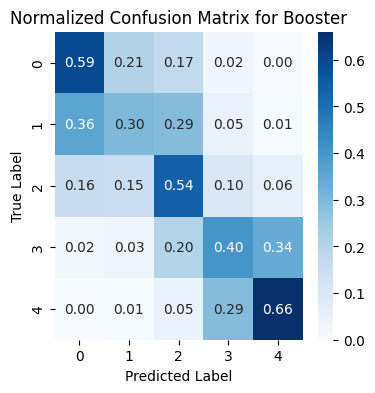

/var/folders/hk/zlc2z4tj3xv3c8bq4srx4y8m0000gq/T/ipykernel_52078/26216509.py:60: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  bench = pd.concat([bench, tempdf])
/var/folders/hk/zlc2z4tj3xv3c8bq4srx4y8m0000gq/T/ipykernel_52078/26216509.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bench = pd.concat([bench, tempdf])


In [4]:

train =xgb.DMatrix(data= X_train,label = y_train)
test = xgb.DMatrix(data= X_test, label = y_test)
params = {'booster': 'gbtree', 'learning_rate': 0.1, 'objective': 'multi:softmax', 'num_class' : 5}
t0= time.time()
model = xgb.train(params=params, dtrain=train, num_boost_round=100, evals=[(train, 'train'), (test, 'eval')])
y_pred = model.predict(test)
model_report()

# Essai Grid base

Fitting 3 folds for each of 8748 candidates, totalling 26244 fits
[CV 1/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.7;, score=0.501 total time=   0.2s
[CV 2/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.7;, score=0.490 total time=   0.2s
[CV 3/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.7;, score=0.489 total time=   0.2s
[CV 1/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.8;, score=0.499 total time=   0.2s
[CV 2/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.8;, score=0.492 total time=   0.2s
[CV 3/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=3, min_chil

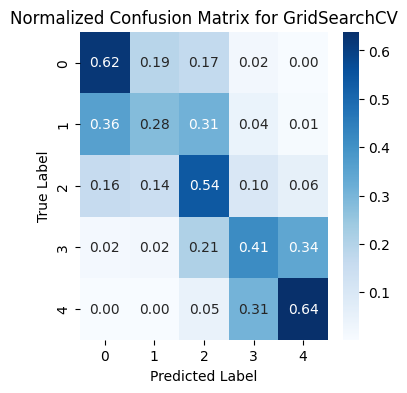

In [5]:
train = xgb.DMatrix(data= X_train,label = y_train)
test = xgb.DMatrix(data= X_test, label = y_test)

params = {'learning_rate': [0.1, 0.01, 0.05],
          'max_depth': [3, 4, 5, 6],
          'min_child_weight': [1, 3, 5],
          'gamma': [0, 0.1, 0.2],
          'subsample': [0.7, 0.8, 0.9],
          'colsample_bytree': [0.7, 0.8, 0.9],
          'reg_lambda': [0, 1, 10],
          'reg_alpha': [0, 0.1, 1]
}
t0= time.time()
xgb_clf = XGBClassifier()
model = GridSearchCV(estimator= xgb_clf, param_grid = params,
                     scoring = 'accuracy', cv = 3,verbose = 3)
model.fit(X_train, y_train)
# Saving the model
from joblib import dump, load
dump(model, '../data/XGBoost_grid_base.joblib')
# pour charger le modèle:
# grid_search = load('../data/XGBoost_grid_base.joblib')

# scores:
model_report()

# Test avec TFIDF

In [11]:
# Vectorization des avis lémmatisés
X_train = review_vector(train_df, ['n_avis','sentiment_norm','longueur_texte'])
X_test = review_vector(test_df,['n_avis','sentiment_norm','longueur_texte'])

train =xgb.DMatrix(data= X_train,label = y_train)
test = xgb.DMatrix(data= X_test, label = y_test)

params = {'learning_rate': [0.1, 0.01, 0.05],
          'max_depth': [3, 4, 5, 6],
          'min_child_weight': [1, 3, 5],
          'gamma': [0, 0.1, 0.2],
          'subsample': [0.7, 0.8, 0.9],
          'colsample_bytree': [0.7, 0.8, 0.9],
          'reg_lambda': [0, 1, 10],
          'reg_alpha': [0, 0.1, 1]}
t0= time.time()
xgb_clf = XGBClassifier()
model = GridSearchCV(estimator= xgb_clf, param_grid = params, scoring = 'accuracy', cv = 3,
                    verbose = 3)
model.fit(X_train, y_train)
# Saving the model
from joblib import dump, load

# After your grid search has completed
dump(model, '../data/XGBoost_grid_tfidf.joblib')
# pour charger le modèle:
# model_load = load('../data/XGBoost_grid_tfidf.joblib')

model_report(model)

Fitting 3 folds for each of 8748 candidates, totalling 26244 fits
[CV 1/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.7;, score=0.571 total time=   2.2s
[CV 2/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.7;, score=0.565 total time=   2.3s
[CV 3/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.7;, score=0.556 total time=   2.2s
[CV 1/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.8;, score=0.571 total time=   2.2s
[CV 2/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1, reg_alpha=0, reg_lambda=0, subsample=0.8;, score=0.563 total time=   2.1s
[CV 3/3] END colsample_bytree=0.7, gamma=0, learning_rate=0.1, max_depth=3, min_chil

In [ ]:
bench = pd.read_csv('../reports/model_benchmark.csv', index_col=0)
bench[bench.model == type(model).__name__]

NameError: name 'model' is not defined